# Разделимость данных

Примените алгоритмы уменьшения размерности к данным из предыдущей лабораторной, объясните полученные результаты

1. С помощью любого из рассмотренных на лекциях алгоритмов снижения размерности спроецируйте тренировочные данные в 2d пространство. Визуализируйте результаты снижения размерности. Цветом обозначьте категорию объекта
1. Примените алгоритм кластеризации к спроецированным данным. Расчитайте средние внутрикластерное и межкласторное расстояния получившейся проекции
1. Опишите результаты 

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
import pandas as pd

In [2]:
df = pd.read_csv('nba2k20-full.csv')
df['b_day'] = df['b_day'].transform(lambda x: int(x.split('/')[2]))
df['height'] = df['height'].transform(lambda x: float(x.split('/')[1]))
df['weight'] = df['weight'].transform(lambda x: int(x.split('/')[0][:3]))
df['salary'] = df['salary'].transform(lambda x: int(x[1:]))
df['salary'] = df['salary'].transform(lambda x: min(2, x//10000000))
df['b_day'] = df['b_day'].transform(lambda x: x + 100 if x < 70 else x)
df.drop(columns=['full_name', 'jersey', 'team', 'position', 'country', 'draft_year', 'draft_round', 'draft_peak', 'college'], inplace=True)
df.head()

,rating,b_day,height,weight,salary
0,97,84,2.06,250,2
1,97,91,2.01,225,2
2,96,94,2.11,242,2
3,96,88,2.08,230,2
4,96,89,1.96,220,2


In [3]:
X = df.drop(columns=['salary'])
y = df[['salary']]

In [4]:
X.head()

,rating,b_day,height,weight
0,97,84,2.06,250
1,97,91,2.01,225
2,96,94,2.11,242
3,96,88,2.08,230
4,96,89,1.96,220


отсюда контент

In [5]:
for col in X.columns:
  X[col] = X[col].apply(lambda x: float(x))
  X[col] = (X[col] - np.mean(X[col]))/np.std(X[col])

In [6]:
pca = PCA(n_components = 2)
X_tr = pca.fit_transform(X)
print('Proportion of variance explained by each component:\n' +\
      '1st component - %.2f,\n2nd component - %.2f\n' %
      tuple(pca.explained_variance_ratio_)) # дисперсия относительно полученных компоненты
print('Directions of principal components:\n' +\
      '1st component:', pca.components_[0],
      '\n2nd component:', pca.components_[1]) # координаты осей пространства
# components - компоненты вектов осей

Proportion of variance explained by each component:
1st component - 0.44,
2nd component - 0.31

Directions of principal components:
1st component: [ 0.21954875 -0.08915234  0.68262148  0.69128729] 
2nd component: [ 0.65879783 -0.71910148 -0.18801814 -0.11630851]


In [7]:
X_df = pd.DataFrame(data = X_tr
             , columns = ['principal component 1', 'principal component 2'])
# две кооры для каждого наблюдения, подтягиванием значение salary
X_full = pd.concat([X_df, y], axis = 1)

In [8]:
X_full

,principal component 1,principal component 2,salary
0,2.590113,3.685860,2
1,1.284166,2.699248,2
2,2.505141,1.747196,2
3,2.032204,2.924675,2
4,0.730542,3.070335,2
...,...,...,...
424,-2.743155,-0.749982,0
425,-1.470841,-0.855619,0
426,-0.144759,-1.763641,0
427,-1.898962,-1.855182,0


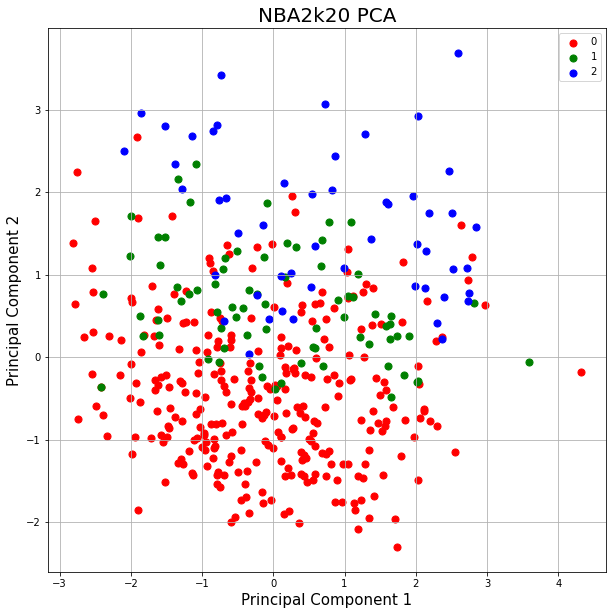

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('NBA2k20 PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = X_full['salary'] == target # к каждому таргету цвет, взяли с с дф все кто таргет
    ax.scatter(X_full.loc[indicesToKeep, 'principal component 1']
               , X_full.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

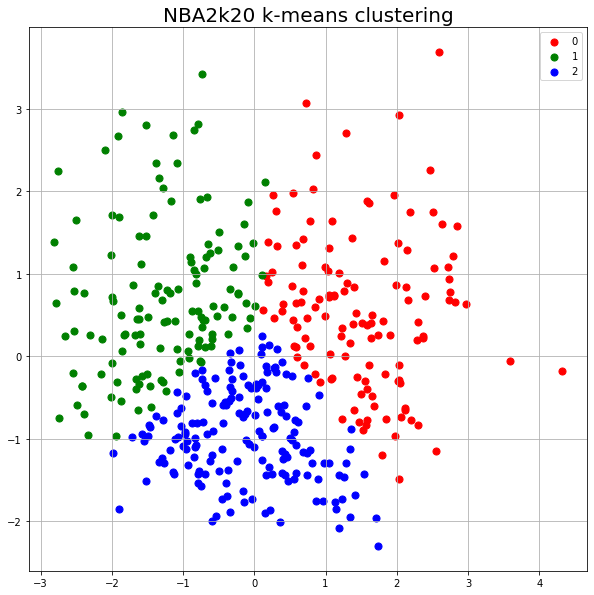

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X) + 1

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1) 

ax.set_title('NBA2k20 k-means clustering', fontsize = 20)

y_pred_df = pd.DataFrame(data = y_pred
             , columns = ['salary'])
X_full_pred = pd.concat([X_df, y_pred_df], axis = 1)

targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = X_full_pred['salary'] == target + 1 # потому что кластеры - 1 2 3, а не 0 1 2
    ax.scatter(X_full_pred.loc[indicesToKeep, 'principal component 1']
               , X_full_pred.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)

ax.legend(targets)
ax.grid()

plt.show()

In [11]:
from sklearn.metrics.pairwise import euclidean_distances

inner_dist = 0 # от точки кластера до всех другрих кластера
for cluster in X_full_pred['salary'].unique():
  M = euclidean_distances(X_full_pred[X_full_pred['salary'] == cluster][['principal component 1', 'principal component 2']], 
                          X_full_pred[X_full_pred['salary'] == cluster][['principal component 1', 'principal component 2']])
  s = 0
  cnt = 0
  for i in range(0, M.shape[0]):
    for j in range(i+1, M.shape[1]):
      s += M[i][j]
      cnt += 1
  
  inner_dist += s/cnt # суммируем внутрикластерные каждого кластера
inner_dist = inner_dist/len(X_full_pred['salary'].unique()) # получаем среднее по всем кластерам

outer_dist = 0 # 
clusters = set(X_full_pred['salary'].unique())
for cluster in clusters:
  new_clusters = clusters - set([cluster])
  s = 0
  cnt = 0
  for cluster_new in new_clusters:
    M = euclidean_distances(X_full_pred[X_full_pred['salary'] == cluster][['principal component 1', 'principal component 2']],
                            X_full_pred[X_full_pred['salary'] == cluster_new][['principal component 1', 'principal component 2']])
    for i in range(0, M.shape[0]):
      for j in range(i+1, M.shape[1]):
        s += M[i][j]
        cnt += 1

  outer_dist += s/cnt
outer_dist = outer_dist/len(X_full_pred['salary'].unique())

In [12]:
inner_dist, outer_dist

(1.4051178350405047, 2.551444181243973)

Видим, что алгоритм kmeans плохо справляется с качественной кластеризацией игороков по нашему таргету при применении алгоритма снижения размерности PCA, однако алгоритм в целом кластеризует наблюдения достаточно качественно